In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

Connect to the SQL base and load the dataframe as a table.
The query `SELECT * FROM candidates LIMIT 5` is equal to `df.head()` in pandas.

In [14]:
df = pd.read_csv("/content/drive/MyDrive/hr-data/aug_test-mod.csv")

conn = sqlite3.connect("job_data.db")

df.to_sql("candidates", conn, if_exists="replace", index=False)

result = pd.read_sql_query("SELECT * FROM candidates LIMIT 5", conn)
print(result)

   enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624   Male   
3        33241  city_115                   0.789   Male   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience       no_enrollment        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline  experience company_size    company_type last_new_job  \
0             STEM          20        50-99         Unknown            1   
1             STEM          15        50-99         Pvt Ltd           >4   
2             STEM  

Let's make a query which returns the number of candidates based on their education level.

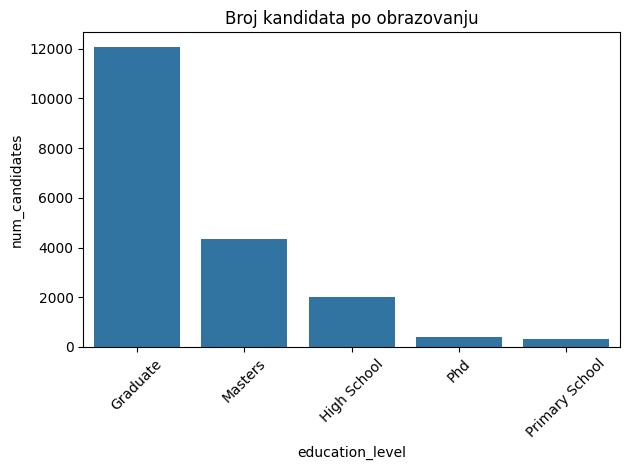

In [7]:
query1 = """
SELECT education_level, COUNT(*) AS num_candidates
FROM candidates
GROUP BY education_level
ORDER BY num_candidates DESC;
"""
df_edu = pd.read_sql_query(query1, conn)
sns.barplot(data=df_edu, x="education_level", y="num_candidates")
plt.title("Broj kandidata po obrazovanju")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's see the average years of experience for each gender:

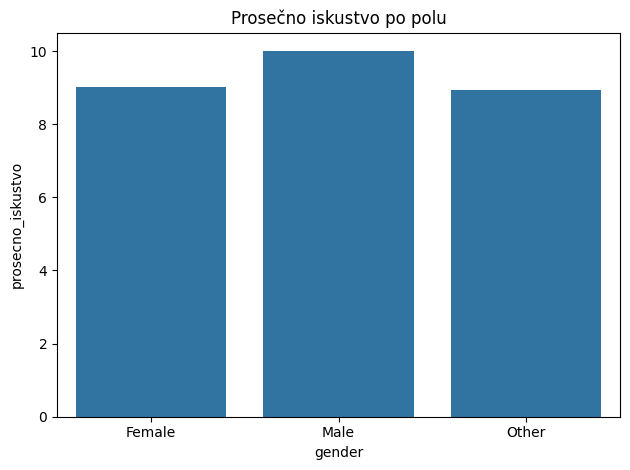

In [8]:
query2 = """
SELECT gender, AVG(experience) AS prosecno_iskustvo
FROM candidates
GROUP BY gender;
"""
df_exp_gender = pd.read_sql_query(query2, conn)
sns.barplot(data=df_exp_gender, x="gender", y="prosecno_iskustvo")
plt.title("Prosečno iskustvo po polu")
plt.tight_layout()
plt.show()

Let's count candidates by their type of company:

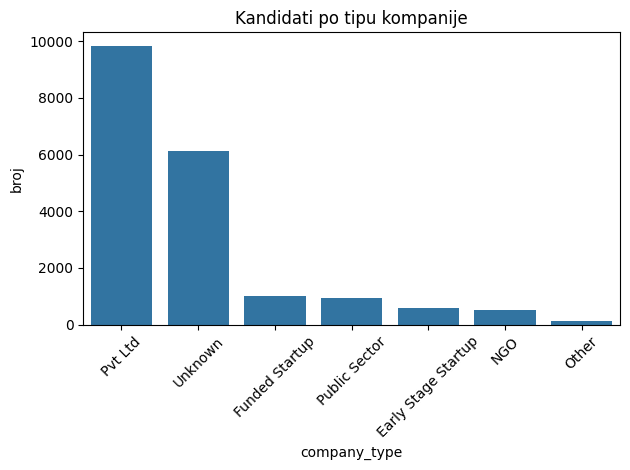

In [9]:
query3 = """
SELECT company_type, COUNT(*) AS broj
FROM candidates
GROUP BY company_type
ORDER BY broj DESC;
"""
df_company = pd.read_sql_query(query3, conn)
sns.barplot(data=df_company, x="company_type", y="broj")
plt.title("Kandidati po tipu kompanije")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's count candidates by years of unemployment:

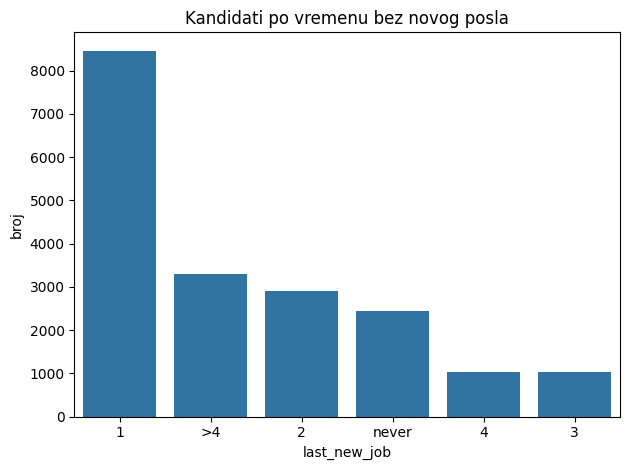

In [10]:
query4 = """
SELECT last_new_job, COUNT(*) AS broj
FROM candidates
GROUP BY last_new_job
ORDER BY broj DESC;
"""
df_newjob = pd.read_sql_query(query4, conn)
sns.barplot(data=df_newjob, x="last_new_job", y="broj")
plt.title("Kandidati po vremenu bez novog posla")
plt.tight_layout()
plt.show()

List top 10 cities by the number of candidates:

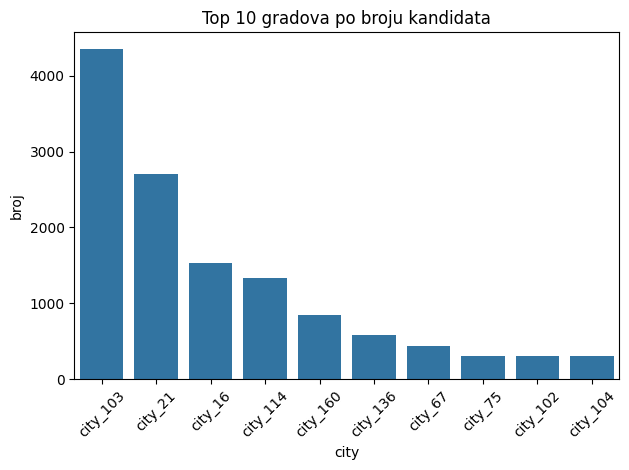

In [11]:
query5 = """
SELECT city, COUNT(*) AS broj
FROM candidates
GROUP BY city
ORDER BY broj DESC
LIMIT 10;
"""
df_city = pd.read_sql_query(query5, conn)
sns.barplot(data=df_city, x="city", y="broj")
plt.title("Top 10 gradova po broju kandidata")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's see which cities have the highest value of `avg_training_hours`, along with the education level of candidates.

We can tell that `city_10` has the highest average, associated with primary education - perhaps we can assume that `city_10` is a working-class city with a strong workforce.

`city_127` has the second-highest average, associated with PhD education - probably a research hub.

In [19]:
query6 = """
SELECT
    city,
    education_level,
    ROUND(AVG(training_hours), 2) AS avg_training_hours
FROM
    candidates
GROUP BY
    city, education_level
ORDER BY
    avg_training_hours DESC;
"""
df_result = pd.read_sql_query(query6, conn)
df_result.head()

,city,education_level,avg_training_hours
0,city_10,Primary School,266.0
1,city_127,Phd,256.0
2,city_91,Primary School,254.0
3,city_144,Phd,210.0
4,city_90,Primary School,198.0


<ipython-input-21-67bfd8b1f773>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_result, x='avg_training_hours', y='education_level', inner='stick', palette='Dark2')


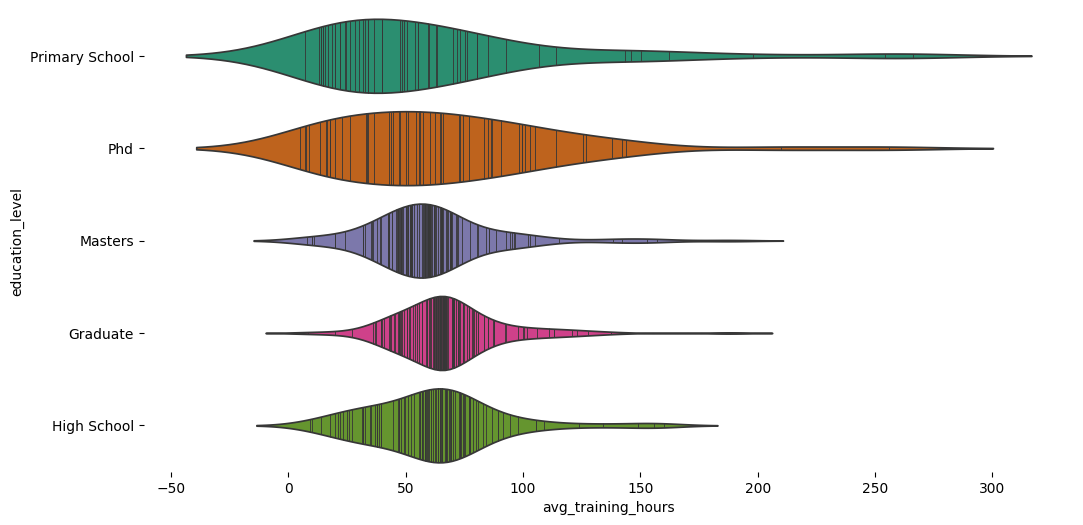

In [21]:
# @title education_level vs avg_training_hours

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_result['education_level'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_result, x='avg_training_hours', y='education_level', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Let's see how job switching is linked to years of experience.
*(target=1 means the candidate is seeking to change jobs)*

In [28]:
query7 = """
SELECT
    experience,
    COUNT(*) AS total_people,
    SUM(CASE WHEN target = 1 THEN 1 ELSE 0 END) AS changed_jobs,
    ROUND(SUM(CASE WHEN target = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(*), 2) AS change_ratio
FROM
    candidates
GROUP BY
    experience
ORDER BY
    experience;
"""

df_result = pd.read_sql_query(query7, conn)
df_result.head()

,experience,total_people,changed_jobs,change_ratio
0,0,522,237,0.45
1,1,549,233,0.42
2,2,1127,374,0.33
3,3,1354,478,0.35
4,4,1403,457,0.33


For each experience level we can see:

*  How many people there are: `total_people`

*  How many are actively looking to change jobs: `changed_jobs`

*  What proportion of that group wants to change: `change_ratio`

We can see from the graph below that inexperienced people are most likely to switch jobs, while the more experienced ones are more grounded.

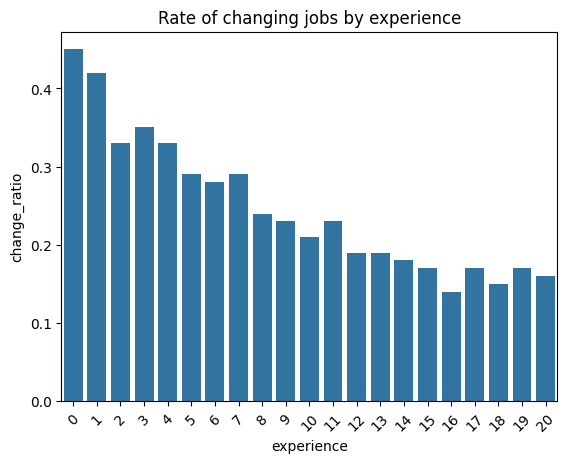

In [29]:
sns.barplot(data=df_result, x='experience', y='change_ratio')
plt.xticks(rotation=45)
plt.title("Rate of changing jobs by experience")
plt.show()

Since we are now connected to the SQL base, we should close the connection after querying to avoid open connections piling up.

*(This is not as important to do in Colab, as the connection will be closed when the session is terminated anyway.)*

In [30]:
conn.close()